# Spatially varying parameters - Mark

## Objectives

The main objective of this tutorial is to demonstrate how spatially varying parameters can be used to model and simulate different geometries and/or materials using JOOMMF. I have modified this notebook in order to simulate a structure similar to the core-shell particle from Anderson and Camley paper.

## Problem specification

The geometry is a **sphere** with

- unit cell length $\Delta=0.228 \,\text{nm}$
- core radius $r_c = 21\cdot\Delta= 4.8\,\text{nm}$ 
- interface thickness $r_i = 2 \cdot\Delta= 0.456\,\text{nm}$ 
- shell thickness $r_s = 10\cdot\Delta= 2.28\,\text{nm}$ 
- domain length $l = 3\cdot(r_c+r_i+r_s)$.

The material parameters for the core are (Gd):

- exchange energy constant $A = 7.7 \times 10^{-22} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 2.01 \times 10^{6} \,\text{A/m}$ at $0~K$ with $T_C=1043~K$.

The material parameters for the shell are (Fe):

- exchange energy constant $A = 2.16 \times 10^{-20} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 1.714 \times 10^{6} \,\text{A/m}$ at $0~K$ with $T_C=289~K$.

Magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = \underbrace{-\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff})}_\text{precession} + \underbrace{\alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)}_\text{damping}$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.5$.

We are interested in computing the equlibrium magnetisation state starting from the uniform magnetisation in the $(1, 1, 1)$ direction.

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [1]:
#import hublib.use
import numpy as np
#%use oommf-1.2b0
import math
import oommfc as oc
import discretisedfield as df
mu0 = 1.25663706212e-6

Here we define a function to account for the temperature dependence of the saturation magnetization $M_s$.

In [2]:
def M_temp(T,M_0,T_0):
    M = M_0 * (1-(T/T_0)**(3/2))
    return M
#
# Dependence of A on M and T found in : "Temperature dependence of the exchange stiffness in F..". Mulazzi et al.
#
def A_temp(T,A_0,M_0,T_0):
    M_t = M_temp(T,M_0,T_0)
    A = A_0 * T * (1-M_t/M_0)**(-2/3)
    return A

We need to define the rectangular finite difference mesh that can contain the entire sphere.

In [3]:
n_1 = 6#21 # number of cells for inner core
n_i = 1 # number of cells in interface
n_2 = 5#10 # number of cells in outer shell
d = 0.228e-9  # discretisation cell (m)
#L = 20e-9  # mesh edge length (m)
L = 3*(n_1 + n_i + n_2)*d
mesh = oc.Mesh(p1=(-L/2, -L/2, -L/2), p2=(L/2, L/2, L/2), cell=(d, d, d))

To illustrate the mesh and discretisation cell:

In [4]:
%matplotlib inline
mesh

Mesh(p1=(-4.104e-09, -4.104e-09, -4.104e-09), p2=(4.104e-09, 4.104e-09, 4.104e-09), cell=(2.28e-10, 2.28e-10, 2.28e-10), pbc=set(), name='mesh')

As usual, we create the system object and define its Hamiltonian and dynamics equation.

In [5]:
#System object
system = oc.System(name="sphere")
# Hamiltonian
#A = 1.3e-11  # exchange energy constant (J/m)
H = (0, 0, 0.2e-3/mu0)  # external magnetic field (A/m)
#
# Here we define the layered geometry
#
A_1 = 7.7e-22
A_i = -8.29e-21
A_2 = 2.16e-20
M_1 = 1.74e6 # core
M_i = -4e5
M_2 = 2.01e6 # shell
T_1 = 1043
T_i = 1
T_2 = 289
T_sys = 30 # temperature of system
def A_value(pos):
    x, y, z = pos
    if z < (n_1 + n_i + n_2) * d:
        r = math.sqrt(x**2 + y**2 + z**2)
        if r <= n_1 * d: # inner core
            return A_1#A_temp(T_sys,A_1,M_1,T_1)
        elif r <= (n_1 + n_i) * d:
            return A_i#A_temp(T_sys,A_i,M_i,T_i)
        elif r <= (n_1 + n_i + n_2) * d:
            return A_2#A_temp(T_sys,A_2,M_2,T_2)    
        else:
            return 0
    else:
        return 0
    
def Ms_function(pos):
    x, y, z = pos
    if z < (n_1 + n_i + n_2) * d:
        r = math.sqrt(x**2 + y**2 + z**2)
        if r <= n_1 * d: # inner core
            return M_temp(T_sys,M_1,T_1)
        elif r <= (n_1 + n_i) * d:
            return M_temp(T_sys,M_i,T_i)
        elif r <= (n_1 + n_i + n_2) * d:
            return M_temp(T_sys,M_2,T_2)   
        else:
            return 0 
    else:
        return 0
    
A =  df.Field(mesh, dim=1, value=A_value)
    
system.hamiltonian = oc.Exchange(A=A) + oc.Demag() + oc.Zeeman(H)

## Dynamics
#gamma = 2.211e5
#alpha = 0.5
#system.dynamics = oc.Precession(gamma) + oc.Damping(alpha)

The Hamiltonian and dynamics equation are:

In [6]:
system.hamiltonian

Exchange(A=Field(mesh=Mesh(p1=(-4.104e-09, -4.104e-09, -4.104e-09), p2=(4.104e-09, 4.104e-09, 4.104e-09), cell=(2.28e-10, 2.28e-10, 2.28e-10), pbc=set(), name='mesh'), dim=1, name='field'), name='exchange') + Demag(name='demag') + Zeeman(H=(0, 0, 159.15494300525526), name='zeeman')

In [7]:
system.dynamics

Having the function defining the sphere geometry, we can now create the initial magnetisation field. The direction of the inital field is determined by the value variable, here $(1, 0, 0)$, i.e., the inital magnetization points into the $x$-direction and the norm should be the saturation magnetisation function we just created.

In [8]:
system.m = df.Field(mesh, value=(1, 0, 0), norm=Ms_function)

We can plot the initial magnetisation by slicing the sphere geometry perpendicular to "z" and "x" axes.

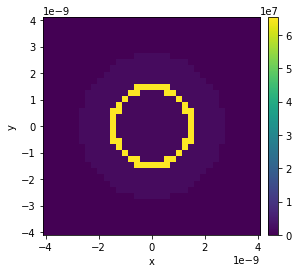

In [9]:
#system.m.norm.k3d_nonzero()
#system.m.plane('z').k3d_vectors(head_size=2)
system.m.x.plane('z').mpl()
#system.m.plot_plane("z")
#system.m.plot_plane("x")

### Relaxing the magnetisation

After we defined all requited parameters of the system, we can relax the system using `MinDriver`.

In [ ]:
md = oc.MinDriver()
md.drive(system, overwrite=True)

2020/02/25 19:35: Running OOMMF (sphere.mif) ... 

And plot the magnetisation in the same slices as before.

In [ ]:
#system.m.x.k3d_voxels(norm_field=system.m.norm)
system.m.x.plane('z').mpl()

<hr>
Cleaning up.  Temporary files were written.  You may want to remove them.

In [ ]:
!rm -rf sphere